In [6]:
import sys
sys.path.append(r"C:\Users\alexz\Documents\GitHub\mirp")

# Tutorial: Applying image filters

This tutorial describes how to apply image filters using MIRP.

## Download example data

Here we use a publicly available [chest CT dataset](https://www.cancerdata.org/resource/doi:10.17195/candat.2016.08.1), that consist of a single image dataset and a mask.

In [4]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

url = r"https://github.com/oncoray/mirp/raw/598293f7afb179b525b49f9b8300a9914fbdebd4/data/tutorial_radiomics_chest_ct_data.zip"

# Specify location where the data is stored.
save_dir = "."

with urlopen(url) as zip_url_pointer:
    with ZipFile(BytesIO(zip_url_pointer.read())) as example_data:
        example_data.extractall(save_dir)

This creates a folder with the following structure:

    chest_ct
     ├─ image
     |  ├─ DCM_IMG_00000.dcm
     |  ├─ ...
     |  └─ DCM_IMG_00059.dcm
     └─ mask
        └─ DCM_RS_00060.dcm

In this example dataset, the CT image slices are stored in DICOM format in the `image` directory. A segmentation mask is stored in DICOM format in the `mask` subdirectory.

## Finding mask labels

Radiomics features are typically computed from regions of interest, such as a tumour. These regions are delineated by experts or auto-segmentation AI, and stored as segmentation masks. MIRP needs to know which mask label (region of interest) should be used for computing features. A first step is to identify which mask labels exist. This can be done using the `extract_mask_labels` function. In this example, we directly provide a path to the mask file (`.../chest_ct/mask/DCM_RS_00060.dcm`).

In [8]:
import os
from mirp import extract_mask_labels

extract_mask_labels(
    mask=os.path.join(save_dir, "chest_ct", "mask", "DCM_RS_00060.dcm"),
)

,sample_name,dir_path,file_path,roi_label,mask_index
0,1,.\chest_ct\mask,DCM_RS_00060.dcm,GTV-1,0


The mask file contains only a single mask, called `GTV-1`.

## Visualising images

It is often useful to inspect images before computing radiomics features. External viewers for DICOM and many other image types exist, but MIRP also has a simple visualisation tool. You can visualise images by exporting them in MIRP internal formats using `extract_images`:

In [9]:
from mirp import extract_images

images = extract_images(
    image=os.path.join(save_dir, "chest_ct", "image"),
    mask=os.path.join(save_dir, "chest_ct", "mask", "DCM_RS_00060.dcm"),
    roi_name="GTV-1",
    image_export_format="native"
)

INFO	: MainProcess 	 2024-04-23 09:52:01,771 	 Initialising image extraction using ct images for 1.


By default, `extract_images` will export dictionaries containing image and mask data (as `numpy.ndarray`) and associated metadata. That way `extract_images` can be used to read and process images as part of an external workflow. The default output can be visualised using `matplotlib` and other tools. Here we use `image_export_format="native"` to export images and masks in the native MIRP format. The output of `extract_images` is a list of images and masks, with one entry per image dataset. We only assess a single image here, which means that `images` only has one element. The nested list always consists of the image -- and any derivatives, such as filtered images -- and masks associated with the image. We can visualise an exported image using its `show` method as follows:

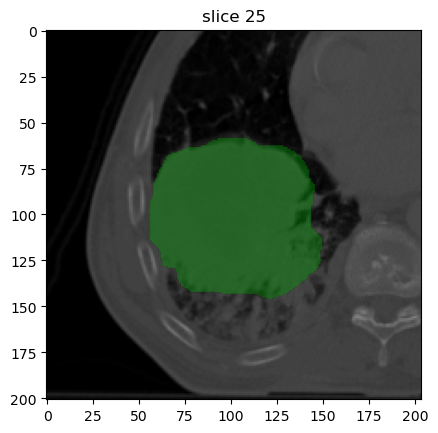

In [18]:
image, mask = images[0]
image[0].show(mask=mask[0], slice_id=25)

Though just an image is shown here, executing this code outside of a Jupyter Notebook will start an interactive plotter that can be scrolled through.

The CT image appears as expected: a large solid tumour is located in the right lung lobe.

## Assessing image metadata

Image metadata are important for understanding the image and how it was acquired and reconstructed. MIRP allows for exporting image metadata from DICOM and other image formats, though for non-DICOM formats metadata will be considerably more limited.

In [19]:
from mirp import extract_image_parameters

extract_image_parameters(
    image=os.path.join(save_dir, "chest_ct", "image")
)

,sample_name,modality,spacing_z,spacing_y,spacing_x,scanner_type,manufacturer,image_type,image_index
0,1,ct,3.0,0.977,0.977,CERR,"CMS, Inc.","['ORIGINAL', 'PRIMARY', 'AXIAL']",0


Only known metadata are shown. For example, tube voltage was not present in the image metadata in this example.

The metadata, and our use case, have important implications for the image processing:

- Since we want to apply filters, we should ensure that pixel or voxel spacing should be isotropic.
- The in-plane resolution is a bit higher than the distance between slices, but can be resampled to isotropic voxels, e.g. 1.0 by 1.0 mm by 1.0 mm. We can apply a filter in 3D.

# Applying filters

Image filters can be used to enhance specific characteristics of an image. Here we will apply to three filters: a mean filter, a Laplacian-of-Gaussian filter, and a non-separable wavelet filter. To do so, we specify the following parameters:

1. Voxels are resampled to 1.0 by 1.0 by 1.0 mm (`new_spacing=1.0`).
2. Select filters (`filter_kernels=["mean", "laplacian_of_gaussian", "nonseparable_wavelet"]`)
3. Set width of the mean filter (in voxels) (`mean_filter_kernel_size=5`).
4. Set width of the Laplacian-of-Gaussian filter (in mm) (`laplacian_of_gaussian_sigma=[1.0, 3.0]`). Here we apply two filters: one with σ = 1.0 mm, and one with σ = 3.0.
5. Use the Simoncelli wavelet (`nonseparable_wavelet_families="simoncelli"`).
6. Find the first three decompositions of the Simoncelli wavelet (`nonseparable_wavelet_decomposition_level=[1, 2, 3]`).

In [32]:
from mirp import extract_images

images = extract_images(
    image=os.path.join(save_dir, "chest_ct", "image"),
    mask=os.path.join(save_dir, "chest_ct", "mask", "DCM_RS_00060.dcm"),
    roi_name="GTV-1",
    image_export_format="native",
    new_spacing=1.0,
    filter_kernels=["mean", "laplacian_of_gaussian", "nonseparable_wavelet"],
    mean_filter_kernel_size=5,
    laplacian_of_gaussian_sigma=[1.0, 3.0],
    nonseparable_wavelet_families="simoncelli",
    nonseparable_wavelet_decomposition_level=[1, 2, 3]
)
image, mask = images[0]

INFO	: MainProcess 	 2024-04-23 11:23:55,822 	 Initialising image extraction using ct images for 1.


Now we can first plot the base image. The base image is always part of the export. Because we resampled the image slices from 3.0 to 1.0 mm, the number of slices increased compared to the original image.

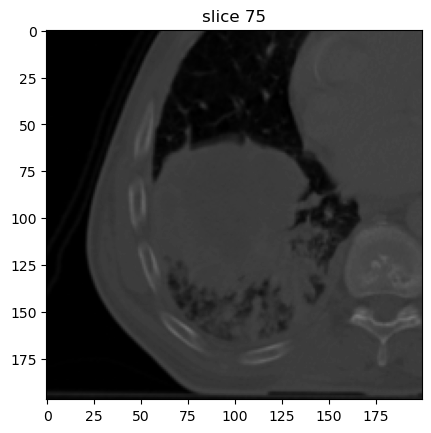

In [25]:
image[0].show(slice_id=75)

Derivative (i.e. filtered) images are stored in the same list as the base image (`image[0]`).

## Mean filter

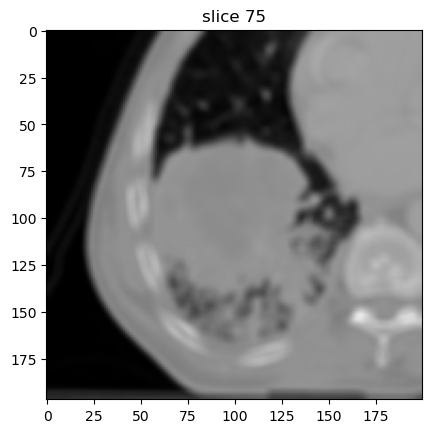

In [26]:
image[1].show(slice_id=75)

## Laplacian-of-Gaussian filter

With σ = 1.0 mm:

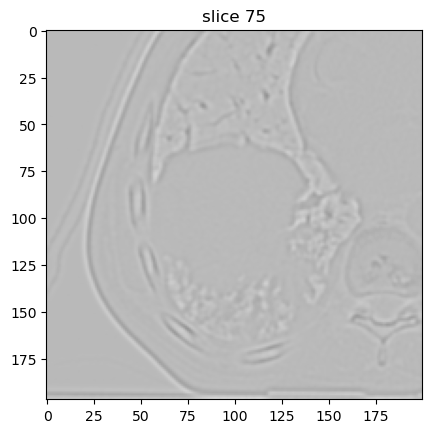

In [28]:
image[2].show(slice_id=75)

With σ = 3.0 mm:

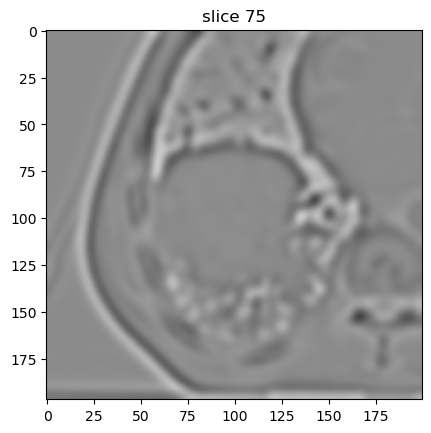

In [29]:
image[3].show(slice_id=75)

## Nonseparable Simoncelli wavelet filter

First decomposition level:

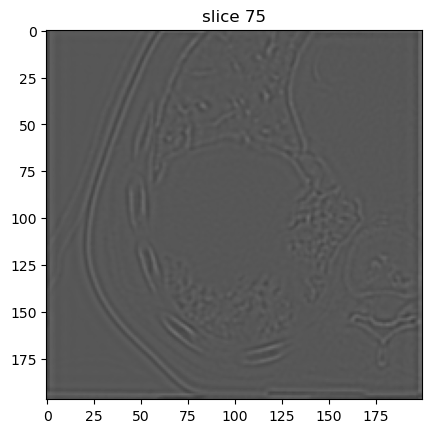

In [30]:
image[4].show(slice_id=75)

Second decomposition level:

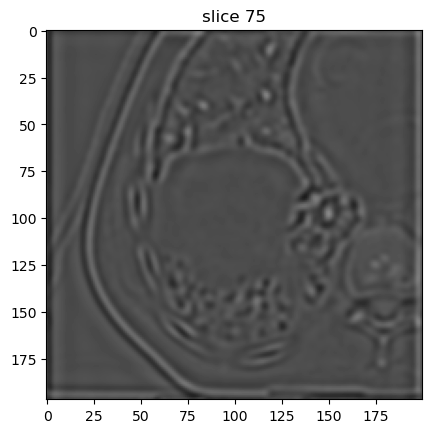

In [31]:
image[5].show(slice_id=75)

Third decomposition level:

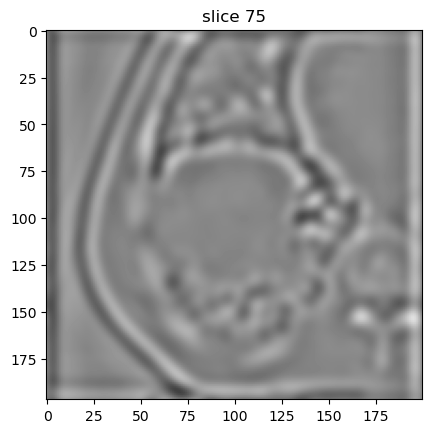

In [33]:
image[6].show(slice_id=75)

## Computing features

Features can also be computed from filtered images. By default, only statistical features are computed, in addition to features computed from the base image.

For the base image, we need to define parameters related to intensity discretisation for computing histogram-based and texture features. Since a CT image consists of Hounsfield units (HU), which are typically calibrated, we will use a *fixed bin size* algorithm (`base_discretisation_method="fixed_bin_size"`) with a bin size of 20 HU (`base_discretisation_bin_size=20.0`). This method requires setting the lowest intensity of the first bin. By default, MIRP uses -1000 HU (corresponding to air). However, this is not always the most useful setting. Here, we will instead specify a soft-tissue window (`resegmentation_intensity_range=[-180.0, 200.0]`), which sets the lowest intensity of the first bin to -180 HU.

In [35]:
import pandas as pd
from mirp import extract_features

features = extract_features(
    image=os.path.join(save_dir, "chest_ct", "image"),
    mask=os.path.join(save_dir, "chest_ct", "mask", "DCM_RS_00060.dcm"),
    roi_name="GTV-1",
    image_export_format="native",
    new_spacing=1.0,
    resegmentation_intensity_range=[-180.0, 200.0],
    base_discretisation_method="fixed_bin_size",
    base_discretisation_bin_width=20.0,
    filter_kernels=["mean", "laplacian_of_gaussian", "nonseparable_wavelet"],
    mean_filter_kernel_size=5,
    laplacian_of_gaussian_sigma=[1.0, 3.0],
    nonseparable_wavelet_families="simoncelli",
    nonseparable_wavelet_decomposition_level=[1, 2, 3]
)

pd.concat(features)

INFO	: MainProcess 	 2024-04-23 11:53:51,671 	 Initialising feature computation using ct images for 1.


,sample_name,image_settings_id,image_modality,image_voxel_size_x,image_voxel_size_y,image_voxel_size_z,image_noise_level,image_noise_iteration_id,image_rotation_angle,image_translation_x,...,wavelet_simoncelli_level_3_stat_max,wavelet_simoncelli_level_3_stat_iqr,wavelet_simoncelli_level_3_stat_range,wavelet_simoncelli_level_3_stat_mad,wavelet_simoncelli_level_3_stat_rmad,wavelet_simoncelli_level_3_stat_medad,wavelet_simoncelli_level_3_stat_cov,wavelet_simoncelli_level_3_stat_qcod,wavelet_simoncelli_level_3_stat_energy,wavelet_simoncelli_level_3_stat_rms
0,1,,ct,1.0,1.0,1.0,0.0,NaN,0.0,0.0,...,531.404254,77.65685,863.020984,61.349115,35.8172,58.114405,3.115791,2.045865,2.349373e+09,88.482671


This results in a `pandas.DataFrame` that has a row per image and mask. The first several columns contain parameters related to that image and mask, and how these were processed. The features computed from filtered images are appended after the features from the base image. These features can be used for, e.g., machine learning using [scikit-learn](https://scikit-learn.org/stable/) or [familiar](https://cran.r-project.org/web/packages/familiar/index.html).